In [ ]:
!pip install torch pandas numpy transformers matplotlib ipywidgets catboost scikit-learn shap seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 119.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 40.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 76.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.4/996.4 kB 71.8 MB/s eta 0:

In [ ]:
import gc
import torch

# PyTorch GPU 캐시 비우기
torch.cuda.empty_cache()

# Python 객체 참조 해제 및 가비지 컬렉션
gc.collect()

[E01][B000] loss=25.0149 | MAE=64.6157 | SMAPE=133.14% | 예측값: [12.113083   2.2570295  3.3532877] | 실제값: [75. 83. 89.]
[E01][B010] loss=155.1593 | MAE=24.2842 | SMAPE=46.36% | 예측값: [56.3334   71.17258  62.669956] | 실제값: [35. 36. 40.]
[E01][B020] loss=53.9123 | MAE=63.8427 | SMAPE=113.98% | 예측값: [81.010925 82.54921  87.63407 ] | 실제값: [24. 19. 16.]
[E01][B030] loss=110.7009 | MAE=31.2729 | SMAPE=37.21% | 예측값: [108.06482 111.12172 124.15851] | 실제값: [107. 114. 120.]
[E01][B040] loss=144.2343 | MAE=61.8780 | SMAPE=102.40% | 예측값: [98.245026 94.210754 94.8762  ] | 실제값: [32. 30. 30.]
[E01][B050] loss=83.2792 | MAE=213.1189 | SMAPE=109.92% | 예측값: [100.59608 119.18333  99.34218] | 실제값: [314. 298. 280.]
[E01][B060] loss=126.6672 | MAE=236.8163 | SMAPE=133.36% | 예측값: [ 4.1211863 89.54384   53.67112  ] | 실제값: [267. 248. 243.]
[E01][B070] loss=136.7855 | MAE=31.8937 | SMAPE=84.14% | 예측값: [47.959473 62.86268  48.82931 ] | 실제값: [18. 18. 21.]
[E01][B080] loss=46.7181 | MAE=57.5788 | SMAPE=97.71% | 예측값: 

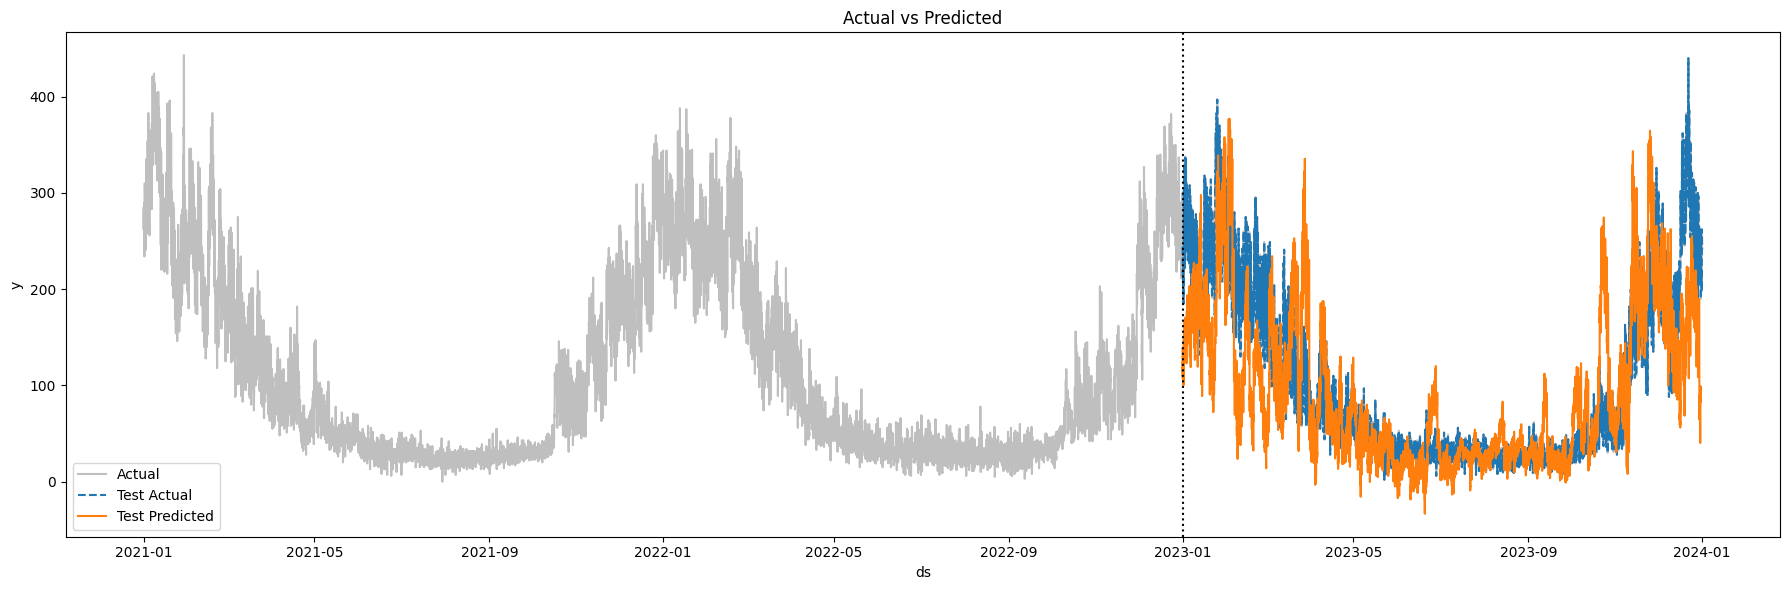

In [5]:
import math
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoConfig, AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

# -----------------------------
# (1) Dataset
# -----------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, target_col="y"):
        self.seq_len   = seq_len
        self.pred_len  = pred_len
        self.target_col= target_col
        self.df        = df.reset_index(drop=True)
        self.features  = [c for c in df.columns if c not in ["ds", target_col]]
        self.data      = df[self.features].values.astype(np.float32)
        self.targets   = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x_enc   = self.data[idx : idx + self.seq_len]
        y_label = self.targets[idx + self.seq_len : idx + self.seq_len + self.pred_len]
        return (
            torch.tensor(x_enc),                # [seq_len, n_features]
            torch.tensor([]),                   # dummy
            torch.tensor(y_label).unsqueeze(-1) # [pred_len, 1]
        )

# -----------------------------
# (2) RevIN
# -----------------------------
class RevIN(nn.Module):
    def __init__(self, num_features, affine=True, eps=1e-5):
        super().__init__()
        self.affine = affine
        self.eps    = eps
        if affine:
            self.gamma = nn.Parameter(torch.ones(1,1,num_features))
            self.beta  = nn.Parameter(torch.zeros(1,1,num_features))

    def forward(self, x, mode):
        if mode == "norm":
            m = x.mean(dim=1, keepdim=True)
            s = x.std(dim=1, keepdim=True)
            xn = (x - m) / (s + self.eps)
            if self.affine:
                xn = xn * self.gamma + self.beta
            return xn, m, s
        elif mode == "denorm":
            xn, m, s = x
            if self.affine:
                xn = (xn - self.beta) / (self.gamma + self.eps)
            return xn * (s + self.eps) + m
        else:
            raise ValueError("mode must be 'norm' or 'denorm'")

# -----------------------------
# (3) PatchEmbedding
# -----------------------------
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, dropout=0.1):
        super().__init__()
        self.patch_len = patch_len
        self.stride    = stride
        self.token_emb = nn.Linear(patch_len, d_model)
        self.dropout   = nn.Dropout(dropout)

    def forward(self, x):
        B, T, F = x.shape
        Lp, S   = self.patch_len, self.stride
        num_patches = math.floor((T - Lp) / S) + 2
        total_len   = (num_patches - 1) * S + Lp
        pad = total_len - T
        if pad > 0:
            x = nn.functional.pad(x, (0,0,0,pad), mode="replicate")
        x = x.permute(0,2,1)                                    # [B, F, T]
        xu = x.unfold(2, Lp, S).contiguous().view(B*F, num_patches, Lp)
        pe = self.token_emb(xu).view(B, F * num_patches, -1)   # [B, F*num_patches, d_model]
        return self.dropout(pe), F, num_patches

# -----------------------------
# (4) ReprogrammingLayer
# -----------------------------
class ReprogrammingLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, dropout=0.1):
        super().__init__()
        d_keys = d_keys or (d_model // n_heads)
        self.n_heads = n_heads
        self.query_proj = nn.Linear(d_model, d_keys * n_heads)
        self.key_proj   = nn.Linear(d_llm,   d_keys * n_heads)
        self.value_proj = nn.Linear(d_llm,   d_keys * n_heads)
        self.out_proj   = nn.Linear(d_keys * n_heads, d_llm)
        self.dropout    = nn.Dropout(dropout)

    def forward(self, tgt, src, val):
        B, L, _ = tgt.shape
        S, _    = src.shape
        H       = self.n_heads
        E       = int(tgt.size(-1) // H)

        Q = self.query_proj(tgt).view(B, L, H, E)    # [B, L, H, E]
        K = self.key_proj(src).view(S, H, E)         # [S, H, E]
        V = self.value_proj(val).view(S, H, E)       # [S, H, E]

        scores = torch.einsum("blhe,she->bhls", Q, K) / math.sqrt(E)
        attn   = torch.softmax(scores, dim=-1)
        attn   = self.dropout(attn)
        out    = torch.einsum("bhls,she->blhe", attn, V).reshape(B, L, H*E)
        return self.out_proj(out)

# -----------------------------
# (5) FlattenHead
# -----------------------------
class FlattenHead(nn.Module):
    def __init__(self, n_vars, num_patches, d_llm, pred_len, dropout=0.1):
        super().__init__()
        in_feats  = n_vars * num_patches * d_llm
        out_feats = pred_len * 1
        self.flatten = nn.Flatten(start_dim=1)
        self.linear  = nn.Linear(in_feats, out_feats)
        self.dropout = nn.Dropout(dropout)
        self.pred_len= pred_len

    def forward(self, x):
        B = x.size(0)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x.view(B, self.pred_len, 1)

# -----------------------------
# (6) TimeLLMMulti
# -----------------------------
class TimeLLMMulti(nn.Module):
    def __init__(
        self, seq_len, pred_len, enc_in,
        d_model=768, d_ff=768, patch_len=48, stride=24,
        llm_layers=6, n_heads=12, dropout=0.1, prompt_maxlen=1024,
        num_prototypes=256
    ):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len= pred_len
        self.enc_in  = enc_in
        self.prompt_maxlen = prompt_maxlen

        # 1) Frozen LLM backbone
        cfg = AutoConfig.from_pretrained(
            "distilgpt2",
            n_embd   = d_ff,
            n_layer  = llm_layers,
            n_head   = n_heads,
            output_hidden_states=False,
            output_attentions=False,
            add_cross_attention=False
        )
        self.llm = AutoModel.from_pretrained("distilgpt2", config=cfg)
        for p in self.llm.parameters():
            p.requires_grad = False
        self.tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # 2) RevIN
        self.revin_in  = RevIN(enc_in)
        self.revin_out = RevIN(enc_in)

        # 3) PatchEmbedding + projection
        self.patch_embed = PatchEmbedding(d_model, patch_len, stride, dropout)
        self.proj_pe     = nn.Linear(d_model, d_ff) if d_model != d_ff else nn.Identity()

        # 4) Text prototypes
        W = self.llm.get_input_embeddings().weight  # [vocab_size, d_ff]
        vocab_size = W.size(0)
        self.mapping_layer = nn.Linear(vocab_size, num_prototypes, bias=False)
        self.prototype_emb = nn.Parameter(self.mapping_layer.weight @ W.detach())

        # 5) Reprogramming
        self.reprog = ReprogrammingLayer(d_model=d_ff, n_heads=n_heads, d_llm=d_ff, dropout=dropout)

        # 6) Prediction head
        max_patches = math.floor((seq_len - patch_len) / stride) + 2
        self.head = FlattenHead(n_vars=enc_in, num_patches=max_patches, d_llm=d_ff, pred_len=pred_len, dropout=dropout)

    def forward(self, x_enc, prompt: str = None):
        B = x_enc.size(0)

        # a) RevIN normalization
        x_norm, mean, std = self.revin_in(x_enc, "norm")

        # b) Patch embedding + projection
        pe, F, num_p = self.patch_embed(x_norm)       # [B, F*num_p, d_model]
        pe = self.proj_pe(pe)                         # [B, F*num_p, d_ff]

        # c) Reprogramming with prototypes
        rep = self.reprog(pe, self.prototype_emb, self.prototype_emb)  # [B, F*num_p, d_ff]

        # d) Prompt embedding
        prompts = [prompt or ""] * B
        ids = self.tokenizer(prompts, padding=True, truncation=True,
                             max_length=self.prompt_maxlen,
                             return_tensors="pt").input_ids.to(x_enc.device)
        p_emb = self.llm.get_input_embeddings()(ids)  # [B, Lp, d_ff]

        # e) Concat and LLM forward
        inp = torch.cat([p_emb, rep], dim=1)          # [B, Lp + F*num_p, d_ff]
        llm_out = self.llm(inputs_embeds=inp).last_hidden_state
        rep_out = llm_out[:, -rep.size(1):, :]        # [B, F*num_p, d_ff]

        # f) Prediction head
        pred = self.head(rep_out)                     # [B, pred_len, 1]

        # g) Denormalize & slice single channel (y only)
        out_all = self.revin_out((pred, mean, std), "denorm")  # [B, pred_len, enc_in]
        out     = out_all[..., 0].unsqueeze(-1)                # [B, pred_len, 1]
        return out

# -----------------------------
# Metrics
# -----------------------------
def calc_metrics(true, pred):
    rmse  = np.sqrt(np.mean((true - pred) ** 2))
    mae   = np.mean(np.abs(true - pred))
    mape  = np.mean(np.abs((true - pred) / (true + 1e-8))) * 100
    smape = 100 * np.mean(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + 1e-8))
    return rmse, mae, mape, smape

# -----------------------------
# Training & Inference
# -----------------------------
if __name__ == "__main__":
    # Load & preprocess
    df = pd.read_csv("A지사_train.csv")
    df["ds"] = pd.to_datetime(df["ds"])
    df = df.rename(columns={
        "TA":"Temperature","WD":"WindDirection","WS":"WindSpeed",
        "RN_DAY":"DailyPrecipitation","RN_HR1":"HourlyPrecipitation",
        "HM":"Humidity","SI":"SolarIrradiance","ta_chi":"ApparentTemperature"
    })
    train_df = df[df["ds"].dt.year.isin([2021,2022])].reset_index(drop=True)
    test_df  = df[df["ds"].dt.year==2023].reset_index(drop=True)

    seq_len, pred_len = 24*7, 24*1
    batch_size, val_ratio = 4, 0.2

    ds      = TimeSeriesDataset(train_df, seq_len, pred_len, "y")
    n_val   = int(len(ds) * val_ratio)
    n_train = len(ds) - n_val
    train_ds, val_ds = random_split(ds, [n_train, n_val])
    tr_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    va_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

    feature_names = train_ds.dataset.features if hasattr(train_ds, "dataset") else train_ds.features

    # Auto-generate English prompt
    feature_importance_str = ", ".join(feature_names[:4]) + " etc. are important for predicting y."
    corr = train_df[feature_names].corrwith(train_df["y"]).sort_values(ascending=False)
    corr_str = "\n".join([f"{c}: corr={v:.2f}" for c,v in corr.items()])
    stats = train_df[feature_names].describe().T
    stats_str = "\n".join([f"{c}: mean={r['mean']:.2f}, std={r['std']:.2f}, min={r['min']:.2f}, max={r['max']:.2f}" for c,r in stats.iterrows()])
    y_s = train_df["y"].describe()
    target_stats_str = f"mean={y_s['mean']:.2f}, std={y_s['std']:.2f}, min={y_s['min']:.2f}, max={y_s['max']:.2f}, skewness={train_df['y'].skew():.2f}, kurtosis={train_df['y'].kurt():.2f}"
    Q1, Q3 = train_df["y"].quantile(0.25), train_df["y"].quantile(0.75)
    outlier_str = f"Target outlier ratio: {((train_df['y']<Q1-1.5*(Q3-Q1))|(train_df['y']>Q3+1.5*(Q3-Q1))).mean()*100:.2f}%"
    pap_prompt = f"""

"""

    # Model, optimizer, scheduler, criterion
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TimeLLMMulti(seq_len, pred_len, len(feature_names)).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5)
    criterion = nn.L1Loss()
    scaler    = GradScaler()

    best_val, patience, counter = float("inf"), 3, 0
    epochs = 50

    # Training loop
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for i, (x, _, y) in enumerate(tr_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast():
                o = model(x, prompt=pap_prompt)
                # y, o shape: [batch, pred_len, 1]
                # shape 맞추기 (예: o = o[..., 0:1])
                if o.shape != y.shape:
                    o = o[..., 0:1]
                loss = criterion(o, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            if i % 10 == 0:
                # MAE, SMAPE 계산
                pred_np = o[0, :, 0].detach().cpu().numpy()
                true_np = y[0, :, 0].detach().cpu().numpy()
                _, mae, _, smape = calc_metrics(true_np, pred_np)
                print(f"[E{epoch:02d}][B{i:03d}] loss={loss.item():.4f} | MAE={mae:.4f} | SMAPE={smape:.2f}% | 예측값: {pred_np[:3]} | 실제값: {true_np[:3]}")
                # 앞의 3개만 출력
        # Validation
        model.eval()
        val_loss, val_mae, val_sm = 0.0, 0.0, 0.0
        with torch.no_grad():
            for x, _, y in va_loader:
                x, y = x.to(device), y.to(device)
                o = model(x, prompt=pap_prompt)
                # y, o shape: [batch, pred_len, 1]
                val_loss += criterion(o, y).item()
                # flatten for metrics
                _, mae, _, sm = calc_metrics(y.cpu().numpy().flatten(), o.cpu().numpy().flatten())
                val_mae += mae
                val_sm  += sm
        val_loss /= len(va_loader)
        val_mae  /= len(va_loader)
        val_sm   /= len(va_loader)
        print(f"Epoch {epoch:02d}| train {train_loss:.4f}| val {val_loss:.4f}| MAE {val_mae:.4f}| SMAPE {val_sm:.2f}%")

        scheduler.step(val_loss)
        if val_loss < best_val:
            best_val, counter = val_loss, 0
            torch.save(model.state_dict(), "best_timellm_noprompt.pt")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break

    # Testing
    model.load_state_dict(torch.load("best_timellm_noprompt.pt"))
    model.eval()
    test_in  = pd.concat([train_df.tail(seq_len), test_df], ignore_index=True)
    test_ds  = TimeSeriesDataset(test_in, seq_len, pred_len, "y")
    preds    = np.full(len(test_df), np.nan)
    start_t  = time.time()
    with torch.no_grad():
        for idx in range(0, len(test_ds), pred_len):
            x, _, _ = test_ds[idx]
            x = x.unsqueeze(0).to(device)
            y_hat = model(x, prompt=pap_prompt)[0,:,0].cpu().numpy()
            end = min(idx + pred_len, len(test_df))
            preds[idx:end] = y_hat[: end-idx]
    elapsed = time.time() - start_t

    rmse, mae, mape, smape = calc_metrics(test_df["y"].values, preds)
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE : {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test SMAPE: {smape:.2f}%")
    print(f"Inference time: {elapsed:.2f}s")

    # Plot results
    df_all = pd.concat([train_df, test_df], ignore_index=True)
    df_plot= pd.DataFrame({"ds": test_df["ds"], "true": test_df["y"], "pred": preds})
    plt.figure(figsize=(18,6))
    plt.plot(df_all["ds"], df_all["y"], label="Actual", color="gray", alpha=0.5)
    plt.plot(df_plot["ds"], df_plot["true"], label="Test Actual", linestyle="--")
    plt.plot(df_plot["ds"], df_plot["pred"], label="Test Predicted")
    plt.axvline(df_plot["ds"].iloc[0], color="black", linestyle=":")
    plt.xlabel("ds"); plt.ylabel("y"); plt.legend(); plt.title("Actual vs Predicted")
    plt.tight_layout(); plt.show()


In [29]:
preds

array([138.58752441, 109.91373444, 110.30233765, ...,  92.8367691 ,
        86.72110748,  82.88267517])

In [30]:
# preds 배열에 결측치가 몇 개인지 확인
print("nan 개수:", np.isnan(preds).sum())
print("전체 길이:", len(preds))
print("nan 비율:", np.isnan(preds).mean())

nan 개수: 0
전체 길이: 8736
nan 비율: 0.0


In [31]:
start_t  = time.time()
preds = []
start_t = time.time()
with torch.no_grad():
    for idx in range(0, len(test_ds), pred_len):
        x, _, _ = test_ds[idx]
        x = x.unsqueeze(0).to(device)
        y_hat = model(x, prompt=pap_prompt)[0,:,0].cpu().numpy()
        preds.extend(y_hat.tolist())
preds = np.array(preds)[:len(test_df)]  # test_df 길이에 맞게 자르기
elapsed = time.time() - start_t
# ...existing code...

In [32]:
# preds 배열에 결측치가 몇 개인지 확인
print("nan 개수:", np.isnan(preds).sum())
print("전체 길이:", len(preds))
print("nan 비율:", np.isnan(preds).mean())

nan 개수: 0
전체 길이: 8736
nan 비율: 0.0


Test RMSE: 60.8392
Test MAE : 42.2586
Test MAPE: 53.51%
Test SMAPE: 48.90%
Inference time: 3.63s


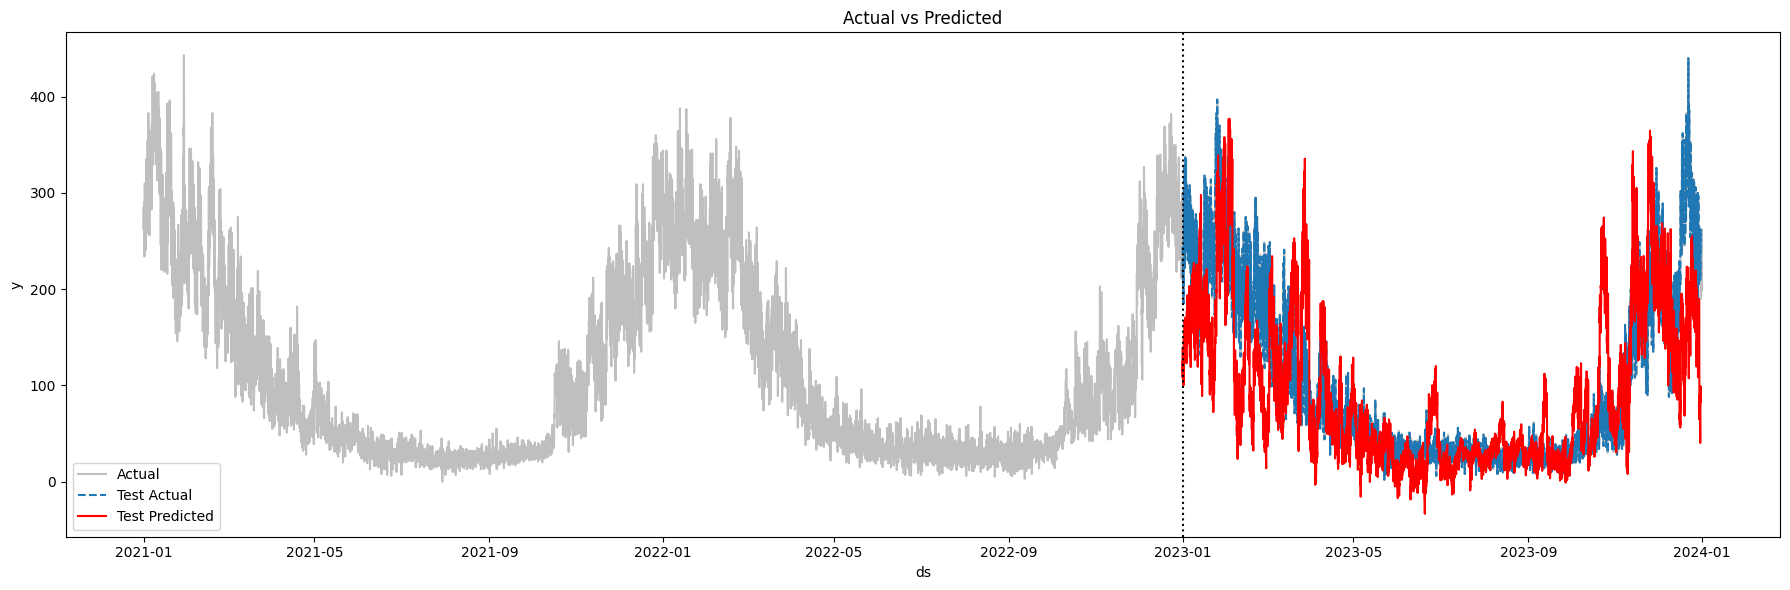

In [42]:
# ...existing code...
%matplotlib inline

# preds 길이에 맞게 test_df도 잘라서 metric 계산

test_df_cut = test_df.iloc[:len(preds)].copy()

rmse, mae, mape, smape = calc_metrics(test_df_cut["y"].values, preds)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Inference time: {elapsed:.2f}s")

# Plot results (예측선을 빨간색으로)
df_all = pd.concat([train_df, test_df], ignore_index=True)
df_plot= pd.DataFrame({"ds": test_df_cut["ds"], "true": test_df_cut["y"], "pred": preds})
plt.figure(figsize=(18,6))
plt.plot(df_all["ds"], df_all["y"], label="Actual", color="gray", alpha=0.5)
plt.plot(df_plot["ds"], df_plot["true"], label="Test Actual", linestyle="--")
plt.plot(df_plot["ds"], df_plot["pred"], label="Test Predicted", color="red")  # 빨간색으로 변경
plt.axvline(df_plot["ds"].iloc[0], color="black", linestyle=":")
plt.xlabel("ds"); plt.ylabel("y"); plt.legend(); plt.title("Actual vs Predicted")
plt.tight_layout(); plt.show()
# ...existing code...

Test RMSE: 60.8392
Test MAE : 42.2586
Test MAPE: 53.51%
Test SMAPE: 48.90%
Inference time: 3.63s


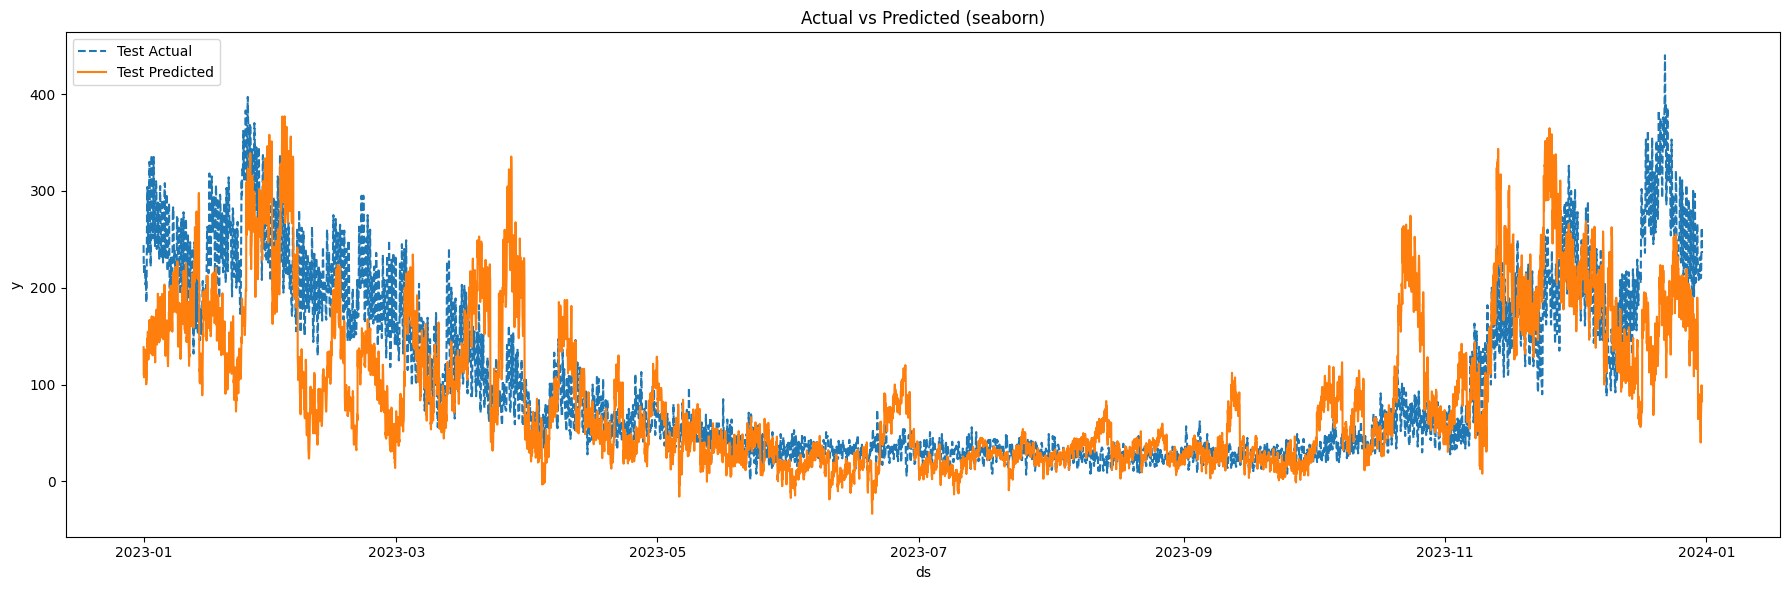

In [38]:
# ...existing code...

import seaborn as sns

# preds 길이에 맞게 test_df도 잘라서 metric 계산
test_df_cut = test_df.iloc[:len(preds)].copy()

rmse, mae, mape, smape = calc_metrics(test_df_cut["y"].values, preds)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Inference time: {elapsed:.2f}s")

# Plot results with seaborn
df_plot = pd.DataFrame({
    "ds": test_df_cut["ds"],
    "true": test_df_cut["y"],
    "pred": preds
})

plt.figure(figsize=(18,6))
sns.lineplot(x="ds", y="true", data=df_plot, label="Test Actual", linestyle="--")
sns.lineplot(x="ds", y="pred", data=df_plot, label="Test Predicted")
plt.xlabel("ds"); plt.ylabel("y"); plt.legend(); plt.title("Actual vs Predicted (seaborn)")
plt.tight_layout(); plt.show()
# ...existing code...